# 4.1 Floating shoe box
![](box.PNG)

In [1]:
import pandas as pd
from mms185 import simpson
from mms185.sympy import lambdify,run
import matplotlib.pyplot as plt
import numpy as np
from numpy import arctan,tan, sin, cos
from sympy import symbols, Eq
import sympy as sp
import pandas as pd

In [2]:
meta_data = {
    'L':30,  # [m]
    'B':9,   # [m]
    'H':6,   # [m]
    'T':2,   # Draft [m]
    'KG':2,  # Vertical center of gravity [m]
}
calculation = {}

### 1. Slope of the GZ curve at φ = 0◦ 

In [3]:
GZ,MS,GM_0,phi = symbols("GZ,MS,GM_0,phi")
eq_GZ_small = Eq(GZ,GM_0*phi)
eq_GZ_small

Eq(GZ, GM_0*phi)

The slope of $GZ$ at small angles is $GM$.

In [4]:
BM_0,KG,KB,mass,I_T,L,B,rho,volume,T = symbols(r"BM_0,KG,KB,Delta,I_T,L,B,rho,\nabla,T")
eq_GM = Eq(GM_0,BM_0+KB-KG)
eq_GM

Eq(GM_0, BM_0 + KB - KG)

In [5]:
eq_BM = Eq(BM_0,I_T*rho/mass)
eq_BM

Eq(BM_0, I_T*rho/Delta)

In [6]:
eq_Delta = Eq(mass,volume*rho)
eq_Delta

Eq(Delta, \nabla*rho)

In [7]:
eq_BM2 = eq_BM.subs(mass,eq_Delta.rhs)
eq_BM2

Eq(BM_0, I_T/\nabla)

In [8]:
eq_I_T = Eq(I_T,L*B**3/12)
eq_I_T

Eq(I_T, B**3*L/12)

In [9]:
eq_volume = Eq(volume, B*L*T)
eq_volume

Eq(\nabla, B*L*T)

In [10]:
calculation['volume'] = run(lambdify(eq_volume), meta_data)

In [11]:
eqs = [
    eq_BM,
    eq_I_T,
    eq_Delta,
    eq_volume,
]
eq_BM3 = Eq(BM_0,sp.solve(eqs, BM_0, I_T, mass, volume, dict=True)[0][BM_0])
eq_BM3

Eq(BM_0, B**2/(12*T))

In [12]:
calculation['BM_0'] = run(lambdify(eq_BM3), meta_data, **calculation)
calculation['BM_0']

3.375

In [13]:
eq_KB = Eq(KB,T/2)
eq_KB

Eq(KB, T/2)

In [14]:
eqs = [
    eq_GM,
    eq_BM3,
    eq_KB,    
]
eq_GM2 = Eq(GM_0, sp.solve(eqs, GM_0, BM_0, KB)[GM_0])
eq_GM2

Eq(GM_0, (B**2 - 12*KG*T + 6*T**2)/(12*T))

In [15]:
expression = eq_GM2.rhs
lambda_GM = sp.lambdify(list(expression.free_symbols),expression)
lambda_GM

<function _lambdifygenerated(B, KG, T)>

In [17]:
calculation['GM_0'] = run(lambda_GM,meta_data)

### 2. GZ when the bilge skims the surface
![](skim.PNG)

First find the distance $x$ which gives the same displacement.

In [18]:
x = symbols("x")

In [19]:
eq_V_phi = Eq(volume,B*L*x/2)
eq_V_phi

Eq(\nabla, B*L*x/2)

In [20]:
eq_x = Eq(x,B*sp.tan(phi))
eq_x

Eq(x, B*tan(phi))

In [21]:
eqs=[
    eq_V_phi,
    eq_x
]
eq_V_phi2 = Eq(volume,sp.solve(eqs, volume,x)[volume])
eq_V_phi2

Eq(\nabla, B**2*L*tan(phi)/2)

In [22]:
eqs = [
    eq_V_phi2,
    eq_volume,
]
eq_phi = Eq(phi, sp.solve(eqs,phi,volume, dict=True)[0][phi])
eq_phi

Eq(phi, atan(2*T/B))

In [23]:
expression = eq_phi.rhs
lambda_phi = sp.lambdify(list(expression.free_symbols),expression)
lambda_phi

<function _lambdifygenerated(B, T)>

In [27]:
calculation['phi'] = lambda_phi(B=meta_data['B'], T=meta_data['T'])
np.rad2deg(calculation['phi'])

23.962488974578182

## Scribantis formula

In [28]:
eq_scribanti = Eq(GZ,(GM_0+sp.Rational(1,2)*BM_0*sp.tan(phi)**2)*sp.sin(phi))
eq_scribanti

Eq(GZ, (BM_0*tan(phi)**2/2 + GM_0)*sin(phi))

In [30]:
calculation['GZ'] = run(lambdify(eq_scribanti),meta_data, **calculation)

In [31]:
calculation

{'volume': 540,
 'BM_0': 3.375,
 'GM_0': 2.375,
 'phi': 0.41822432957922906,
 'GZ': 1.0999583455614206}

### 3. GZ for φ = 90◦ (including the slope of the GZ curve at this point) 

In [32]:
meta_data2 = {
    'L':meta_data['L'],
    'B':meta_data['H'],
    'KG':meta_data['B']/2,
}
meta_data2['T'] = calculation['volume']/(meta_data2['L']*meta_data2['B']) 
meta_data2   

{'L': 30, 'B': 6, 'KG': 4.5, 'T': 3.0}

In [33]:
calculation2 = {}
calculation2['GM_0'] = run(lambda_GM, meta_data2, **calculation)

In [71]:
calculation2

{'GM_0': -2.0}

In [64]:
phis = np.linspace(0,calculation['phi'],100)
df = pd.DataFrame()
df['phi']=phis
df['phi_deg']=np.rad2deg(df['phi'])
df.set_index('phi_deg', inplace=True)
lambda_scibanti = lambdify(eq_scribanti)
df['GZ'] = run(lambda_scibanti,BM_0=calculation['BM_0'], GM_0=calculation['GM_0'], phi=phis)

In [69]:
df['GM_0*phi'] = run(lambdify(eq_GZ_small), GM_0=calculation['GM_0'], phi=phis)

Text(0.5, 0, 'Heel angle $\\phi$ $[deg]$')

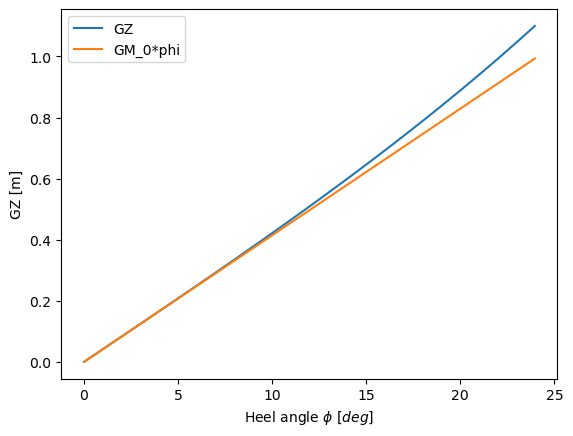

In [73]:
fig,ax=plt.subplots()
df.plot(y=['GZ','GM_0*phi'],ax=ax)
ax.set_ylabel('GZ [m]')
ax.set_xlabel(r'Heel angle $\phi$ $[deg]$')